In [1]:
from src.modeling.cnn_vae import CNN_VAE
from src.data.df_dataset import DfDataset

import torch.nn.functional as F

from torch.optim import Adam
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from src.data.factors

In [2]:
model = CNN_VAE.load_from_checkpoint(  
    "/Users/tobiaochsner/Documents/ETH/GeneticFitness/data/models/cnn_vae_synonymous_batches/epoch=43-val_loss=0.34.ckpt"
)

In [27]:
df = pd.read_csv("/Users/tobiaochsner/Documents/ETH/GeneticFitness/data/output_history/cnn_vae_synonymous_batches_2023_11_08_15_56_26/with_factors.csv")
correlation_df = pd.read_csv("/Users/tobiaochsner/Documents/ETH/GeneticFitness/data/output_history/cnn_vae_synonymous_batches_2023_11_08_15_56_26/correlation.csv")
dataset = DfDataset(df, ["rna_loops", "sequence_dna", "mutated_wildtype_dna"])

In [28]:
from __future__ import print_function

from collections import OrderedDict

import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import functional as F
import os


class GradCAM(nn.Module):

    def __init__(self, model, target_layer):
        super(GradCAM, self).__init__()

        self.model = model
        
        self.model.eval()
        self.target_layer = target_layer
        self.outputs_backward = OrderedDict()
        self.outputs_forward = OrderedDict()
        self.set_hook_func()

    def set_hook_func(self):
        def func_b(module, grad_in, grad_out):
            self.outputs_backward[id(module)] = next(x for x in grad_out if x is not None).cpu()

        def func_f(module, input, f_output):
            self.outputs_forward[id(module)] = f_output

        for module in self.model.named_modules():
            module[1].register_full_backward_hook(func_b)
            module[1].register_forward_hook(func_f)

    def forward(self, *input):
        return self.model(*input)

In [29]:
loader = DataLoader(dataset, batch_size=len(dataset))
all_items = next(iter(loader))

In [30]:
model

CNN_VAE(
  (embedding): Embedding(3, 32)
  (encoder): Sequential(
    (0): Conv1d(32, 32, kernel_size=(5,), stride=(1,))
    (1): ReLU()
    (2): Conv1d(32, 32, kernel_size=(5,), stride=(1,))
    (3): ReLU()
    (4): Conv1d(32, 32, kernel_size=(5,), stride=(1,))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=3360, out_features=32, bias=True)
    (8): ReLU()
  )
  (mu): Linear(in_features=32, out_features=5, bias=True)
  (var): Linear(in_features=32, out_features=5, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=5, out_features=3360, bias=True)
    (1): ReLU()
    (2): Unflatten(dim=1, unflattened_size=(32, 105))
    (3): ConvTranspose1d(32, 32, kernel_size=(5,), stride=(1,))
    (4): ReLU()
    (5): ConvTranspose1d(32, 32, kernel_size=(5,), stride=(1,))
    (6): ReLU()
    (7): ConvTranspose1d(32, 32, kernel_size=(5,), stride=(1,))
  )
)

In [31]:
gradcam = GradCAM(model, target_layer="encoder.1")

In [32]:
gradcam.eval()
input_embedding, output_embedding, mu, var = gradcam(all_items)

target_attentions = []

for i in [2, 3]:
    gradcam.zero_grad()
    score_i = torch.sum(mu[:, i])
    score_i.backward(retain_graph=True)
    
    target_layer_id = id(dict(gradcam.model.named_modules())[gradcam.target_layer])
    target_gradients = gradcam.outputs_backward[target_layer_id]

    target_alpha = torch.mean(target_gradients, dim=2, keepdim=True)

    target_activations = gradcam.outputs_forward[target_layer_id]

    target_attention = target_alpha * target_activations
    target_attention = torch.sum(target_attention, dim=1)
    target_attention = F.relu(target_attention)

    target_attentions.append(target_attention)

target_attentions = torch.mean(torch.stack(target_attentions), dim=0)

In [33]:
target_activations.shape

torch.Size([4164, 32, 113])

<BarContainer object of 113 artists>

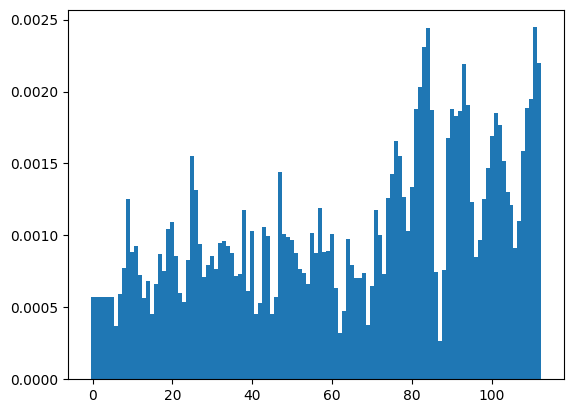

In [34]:
plt.bar(range(len(target_attentions[4])), target_attentions.mean(0).detach().numpy(), width=1)